In [27]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter

current_directory = os.getcwd()
# Read the JSON file containing the Session Directory
with open(current_directory+'\\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)
    
# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.drop(columns=['seconds'],inplace=True)

# applying savgol filter to mocap data 
df_mocap = pd.DataFrame(savgol_filter(df_mocap, int(len(df_mocap)/80) * 2 + 3, 3, axis=0),
                                columns=df_mocap.columns,
                                index=df_mocap.index)

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe_filtered.csv')

# Creating a presentation to save the graphs in
prs=Presentation()

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

In [28]:
def pvt_mpipe(x,t,ylabel='Angle (degrees)'):
    y=[]
    c=0
    for i in range(len(x)):
        if math.isnan(x[i]):
            try:
                t.pop(i-c)
                c+=1
            except:
                c+=1
                t.pop(i-c)
        else:
            y.append(x[i])
    try:
        w = savgol_filter(y,  int(len(y)/20),3)
    except:
        w = savgol_filter(y,  int(len(y)/20)+1,3)

    while len(w) > len (t):
        w.pop()
    while len(w) < len (t):
        t.pop()
    plt.plot(t,w)
    plt.ylabel(ylabel)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def pvt(x,t):
    y=[]
    for i in x:
        y.append(i)
    plt.plot(t,y)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(1)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.5), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

In [29]:
# Finding the calibration frame
f = False
for ind, val in enumerate(df_mocap['epoch_time'].tolist()):
    for i, v in enumerate(df_mpipe['epoch_time'].tolist()):
        if v == round(val,3):
            print(ind, i, round(val,3))
            mpipe_cf = ind
            mocap_cf = i
            f = True
            break
    if f:
        break

# If no matching calibration frame is found, set default calibration frames
if not f:
    mpipe_cf = 10
    mocap_cf = 100

# print('\n-----------------------\n')

# # Printing additional matches if available
# matches=[]
# for ind, val in enumerate(df_mpipe['epoch_time'].tolist()):
#     for i, v in enumerate(df_mocap['epoch_time'].tolist()):
#         if v == round(val,3):
#             # print(ind, i, val)
#             matches.append((ind, i, val))

# print(len(matches))


95 5 1688795861.824


In [30]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []

# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

# Calculate left elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))

# Calculate left elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LW_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

RMSE of Right Elbow Angle:40.4392 
Max error :89.3875


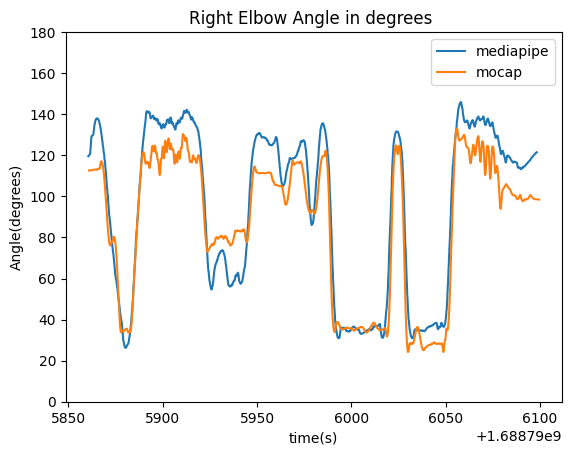

RMSE of Left Elbow Angle:30.9749 
Max error :127.5963


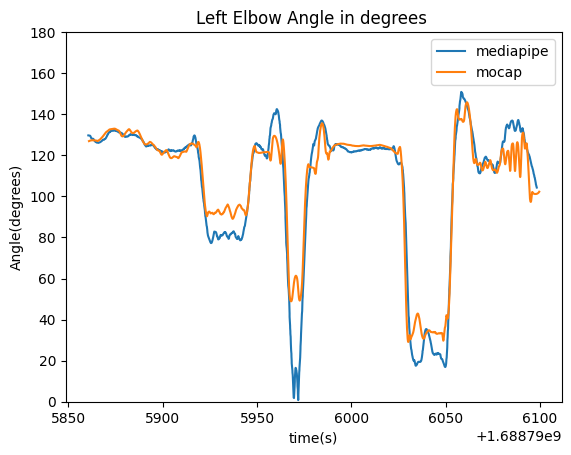

<Figure size 640x480 with 0 Axes>

In [31]:
# graph right elbow angle 
pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'].tolist())
pvt(mocapRightElbowAngle,df_mocap['epoch_time'].tolist())
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me=RMSE(mocapRightElbowAngle,mpipeRightElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of Right Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.show()

# Clear the figure for the next graph
plt.clf()

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'].tolist())
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'].tolist())
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me=RMSE(mocapLeftElbowAngle,mpipeLeftElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of Left Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [32]:
df_mocap.rename(columns={'ls_x':'LS_x','ls_y':'LS_y','ls_z':'LS_z','le_x':'LE_x','le_y':'LE_y','le_z':'LE_z','lw_x':'LW_x','lw_y':'LW_y','lw_z':'LW_z',
                         'rs_x':'RS_x','rs_y':'RS_y','rs_z':'RS_z','re_x':'RE_x','re_y':'RE_y','re_z':'RE_z','rw_x':'RW_x','rw_y':'RW_y','rw_z':'RW_z',
                         'tr_x':'TR_x','tr_y':'TR_y','tr_z':'TR_z'},inplace=True)
df_mpipe.rename(columns={'ls_x':'LS_x','ls_y':'LS_y','ls_z':'LS_z','le_x':'LE_x','le_y':'LE_y','le_z':'LE_z','lw_x':'LW_x','lw_y':'LW_y','lw_z':'LW_z',
                         'rs_x':'RS_x','rs_y':'RS_y','rs_z':'RS_z','re_x':'RE_x','re_y':'RE_y','re_z':'RE_z','rw_x':'RW_x','rw_y':'RW_y','rw_z':'RW_z',
                         'tr_x':'TR_x','tr_y':'TR_y','tr_z':'TR_z'},inplace=True)

In [33]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)

        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])
        try:
            v1,v2=basis[0],basis[1]
        except:
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (abs(w) > 0).any():
            basis.append(w/np.linalg.norm(w))
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [34]:
# callibrating shoulders and trunk

RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [35]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(mpipe_rotated_RS_Cframe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(mpipe_rotated_LS_Cframe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)

    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(mocap_rotated_RS_Cframe,mocapRSF)
    mocapLS_rotmat=rotation_matrix(mocap_rotated_LS_Cframe,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    if mocapRightElbowAngle[i] < eath:
        mocapRSIE.append(RSeuler[2])
    else:
        mocapRSIE.append(np.nan)

    mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    if mocapLeftElbowAngle[i] < eath:
        mocapLSIE.append(LSeuler[2])
    else:
        mocapLSIE.append(np.nan)
    
    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

RMSE of trunk forward/backward: 42.6103 
Max error :122.3395


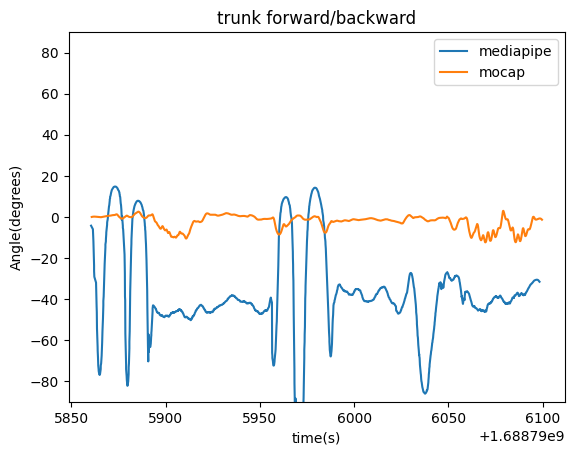

RMSE of trunk left/right: 11.0646 
Max error :48.3822


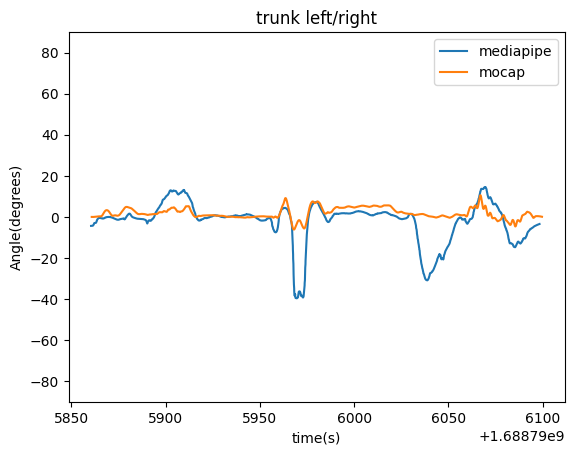

RMSE of trunk rotation: 8.7471 
Max error :42.6136


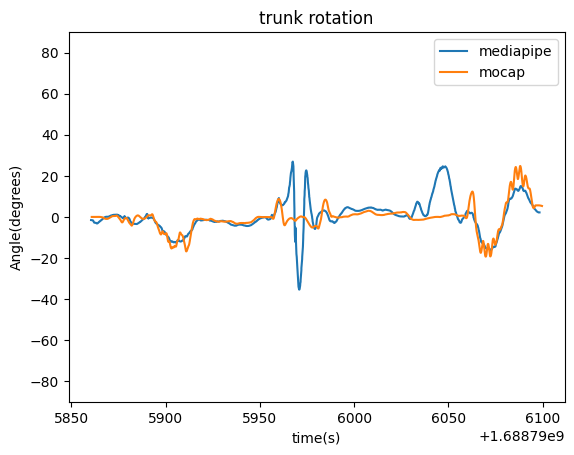

<Figure size 640x480 with 0 Axes>

In [36]:
# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'].tolist())
pvt(mocapTRFB,df_mocap['epoch_time'].tolist())
plt.title('trunk forward/backward')
plt.ylim(-90,90)
rmse,me = RMSE(mocapTRFB,mpipeTRFB,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of trunk forward/backward: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()


pvt(mpipeTRLR,df_mpipe['epoch_time'].tolist())
pvt(mocapTRLR,df_mocap['epoch_time'].tolist())
plt.title('trunk left/right')
plt.ylim(-90,90)
rmse,me = RMSE(mocapTRLR,mpipeTRLR,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of trunk left/right: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeTRRO,df_mpipe['epoch_time'].tolist())
pvt(mocapTRRO,df_mocap['epoch_time'].tolist())
plt.title('trunk rotation')
plt.ylim(-90,90)
rmse,me = RMSE(mocapTRRO,mpipeTRRO,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of trunk rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

RMSE of right shoulder flexion/extension: 30.4304 
Max error :17.0714


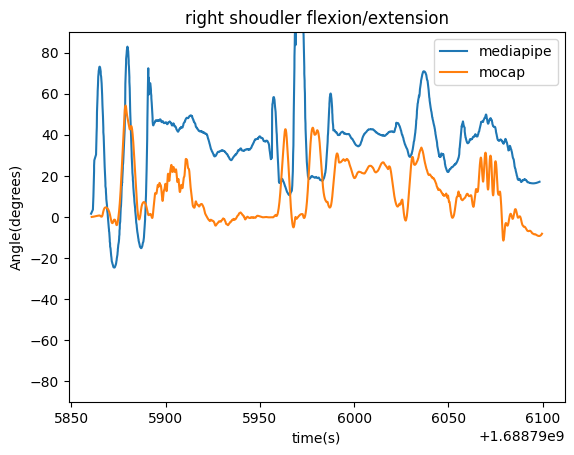

RMSE of right shoulder abduction/adduction: 13.3535 
Max error :30.4464


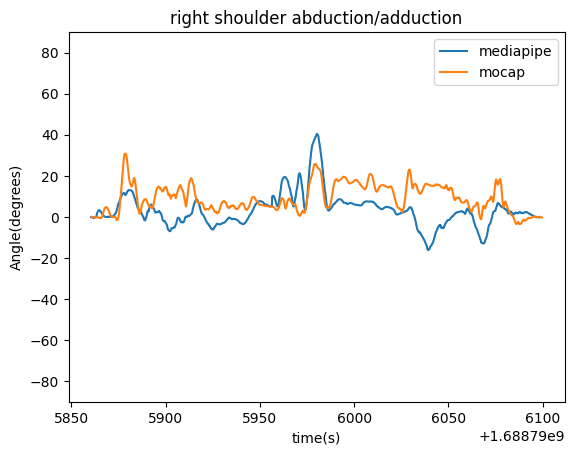

RMSE of right shoulder internal/external rotation: 28.1787 
Max error :78.6384


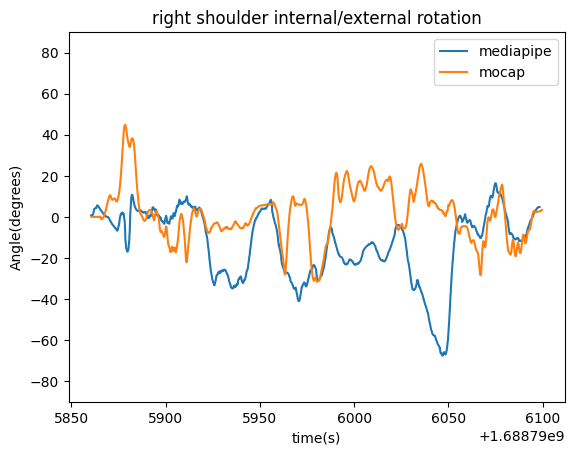

RMSE of left shoulder flexion/extension: 38.3853 
Max error :148.9940


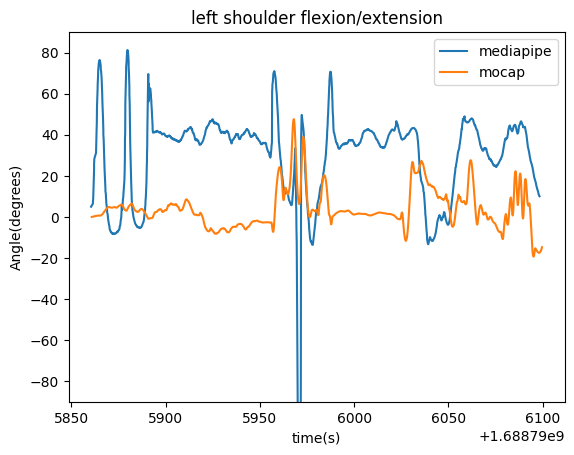

RMSE of left shoulder abduction/adduction: 8.0145 
Max error :24.0556


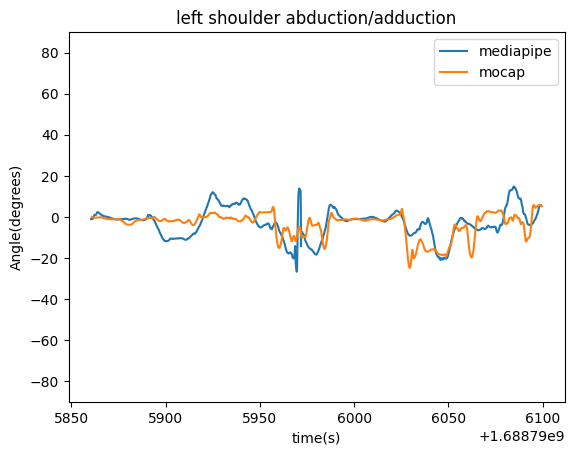

RMSE of left shoulder internal/external rotation: 26.8548 
Max error :26.0354


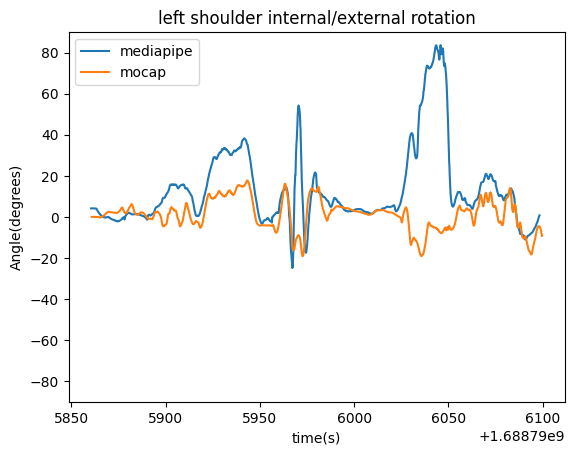

<Figure size 640x480 with 0 Axes>

In [37]:
# Plotting the shoulder angles
pvt(mpipeRSFE,df_mpipe['epoch_time'].tolist())
pvt(mocapRSFE,df_mocap['epoch_time'].tolist())
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')
plt.ylim(-90,90)
rmse,me = RMSE(mocapRSFE,mpipeRSFE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of right shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeRSAA,df_mpipe['epoch_time'].tolist())
pvt(mocapRSAA,df_mocap['epoch_time'].tolist())
plt.title('right shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me = RMSE(mocapRSAA,mpipeRSAA,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of right shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

try:
    pvt(mpipeRSIE,df_mpipe['epoch_time'].tolist())
    pvt(mocapRSIE,df_mocap['epoch_time'].tolist())
    plt.title('right shoulder internal/external rotation')
    plt.ylim(-90,90)
    rmse, me = RMSE(mocapRSIE,mpipeRSIE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
    RMSE_str='RMSE of right shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
    print(RMSE_str)

    # Save the graph to an in-memory buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Save the buffer to a list
    graphs.append(buffer)
    RMSEs.append(RMSE_str)

    plt.show()

    # Clear the figure for the next graph
    plt.clf()
except:
    pass
pvt(mpipeLSFE,df_mpipe['epoch_time'].tolist())
pvt(mocapLSFE,df_mocap['epoch_time'].tolist())
plt.title('left shoulder flexion/extension')
plt.ylim(-90,90)
rmse, me =RMSE(mocapLSFE,mpipeLSFE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of left shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeLSAA,df_mpipe['epoch_time'].tolist())
pvt(mocapLSAA,df_mocap['epoch_time'].tolist())
plt.title('left shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me = RMSE(mocapLSAA,mpipeLSAA,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
RMSE_str='RMSE of left shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

try:
    pvt(mpipeLSIE,df_mpipe['epoch_time'].tolist())
    pvt(mocapLSIE,df_mocap['epoch_time'].tolist())
    plt.title('left shoulder internal/external rotation')
    plt.ylim(-90,90)
    rmse, me = RMSE(mocapLSIE,mpipeLSIE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy())
    RMSE_str='RMSE of left shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}")
    print(RMSE_str)

    # Save the graph to an in-memory buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Save the buffer to a list
    graphs.append(buffer)
    RMSEs.append(RMSE_str)

    plt.show()

    # Clear the figure for the next graph
    plt.clf()
except:
    pass

In [38]:
# delete the previous graphs pptx if it exists
try:
    os.remove(pth+'\\graphs.pptx')
except:
    pass
# Save the graphs to the PowerPoint presentation
for graph,error in zip(graphs,RMSEs):
    save_graph_to_pptx(prs, graph, error)

# Save the presentation
prs.save(pth+'\\graphs.pptx')

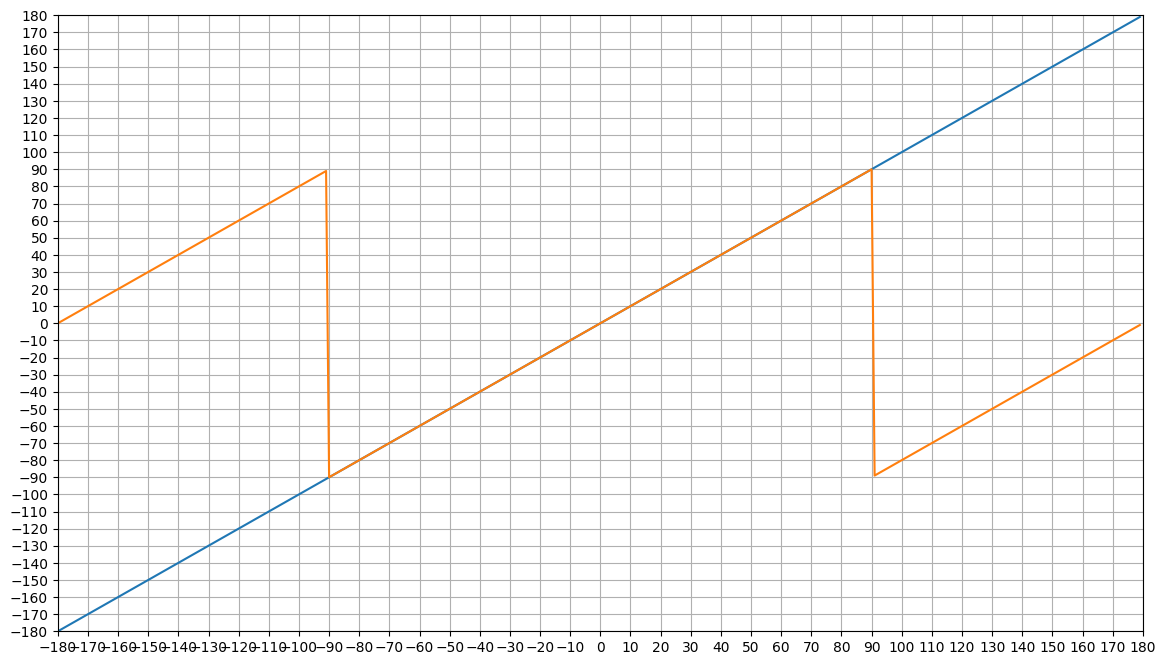

In [39]:
from matplotlib.ticker import MultipleLocator

myval = []
nval,cval=[],[]
start,stop= -180,180
for i in range(start,stop):
    myval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))

    theta=i
    c=np.tan(np.deg2rad(theta))
    theta_check = False
    if theta < 0: 
        theta_check = True 
    
    if not theta_check:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(180+np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
    else:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i))))-180)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data
ax.plot(range(start,stop),cval)
ax.plot(range(start,stop),myval)

# Set the major ticks on the y-axis to be at multiples of 10
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))

# Show the grid lines
ax.grid(True)
plt.ylim(-180,180)
plt.xlim(-180,180)
plt.show()